# Neural Network from Scratch

The code is based on two sources:
- youtube videos by 3blue1brown
  - basic description of the problem and the architecture of the neural network - https://www.youtube.com/watch?v=aircAruvnKk
  - following videos going more into details of the learning process and back propagation - https://www.youtube.com/watch?v=IHZwWFHWa-w and https://www.youtube.com/watch?v=Ilg3gGewQ5U
  - be aware that the back propagation part is very technical and based on concepts from calculus (derivatives and gradients)
- tutorial https://zhenye-na.github.io/2018/09/09/build-neural-network-with-mnist-from-scratch.html

## Import libraries and basic tools

In [4]:
# import of common python libraries
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
# set size to plots to 12, 6
plt.rcParams['figure.figsize'] = 6, 3
import seaborn as sns

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

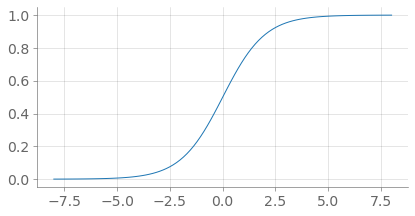

In [5]:
xs = np.linspace(-8, 8, 100)
sns.lineplot(xs, sigmoid(xs))

In [6]:
# one-hot encoding
def one_hot(arr):
    res = np.zeros((arr.size, arr.max() + 1))
    res[np.arange(arr.size), arr] = 1
    return res

In [7]:
one_hot(np.array([0, 2, 1, 1, 0]))

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]])

In [8]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=0)

In [9]:
# loss function - the cost we try to minimize
def loss_mean_squared_errors(Y, Y_hat):
    return np.sum((Y - Y_hat) ** 2) / Y.shape[1]

## MNIST data

(Modified National Institute of Standards and Technology database)

Hello World of Machine Learning

In [10]:
# loading of MNIST data stored on the drive
X_raw = np.load('data\\mnist_x.npy')
Y_raw = np.int_(np.load('data\\mnist_y.npy', allow_pickle=True))

# basic transformation
X = (X_raw / 255).astype('float32').T
Y = one_hot(Y_raw).T

permutation = np.random.permutation(X.shape[1])
train_size = 60_000

X_train = X[:, permutation[:train_size]]
Y_train = Y[:, permutation[:train_size]]
X_test = X[:, permutation[train_size:]]
Y_test = Y[:, permutation[train_size:]]

In [13]:
X[0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

Label = 5, Y = [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


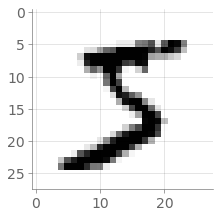

In [11]:
# show one image
n = 0
plt.imshow(X[:,n].reshape(28, 28), cmap=plt.cm.gray_r, interpolation='nearest', vmin=0, vmax=1)
print(f'Label = {Y_raw[n]}, Y = {Y[:,n]}')

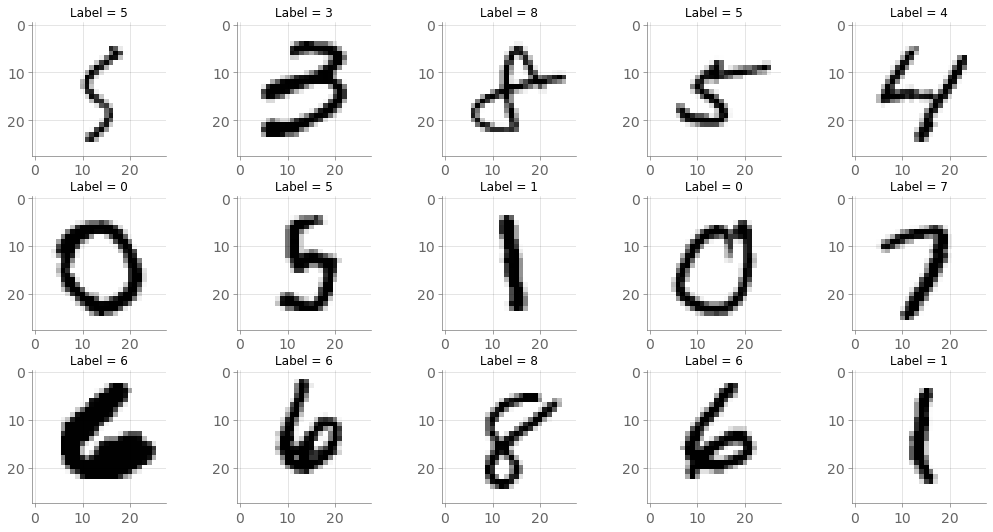

In [12]:
# show multiple images
plt.rcParams['figure.figsize'] = 16, 8

fig, ax = plt.subplots(3, 5)
plt.subplots_adjust(hspace=0.3)
perm = np.random.permutation(X.shape[1])[:15]
for i, n in enumerate(perm):
    ax[i // 5][i % 5].imshow(X[:,n].reshape(28, 28), cmap=plt.cm.gray_r, interpolation='nearest', vmin=0, vmax=1)
    ax[i // 5][i % 5].set_title(f'Label = {Y_raw[n]}')
plt.rcParams['figure.figsize'] = 12, 6

## Neural Network

Plain vanilla neural network - fully connected with two hidden layers.
- sigmoid activation for all layers

There are five parts in the next code:
1. **Setup and random initialization** of neural network
2. **Feed forward** - for a given input image, calculate what the neural network thinks it is
3. **Back propagation** - the inner component of the learning process itself. This is where the magic happens.
4. **Iteration over data** and learning - the outer component of the learning process
5. **Inspecting** of the neural network and its performance

### 1. Setup and random initialization

The architecture of the neuron network is defined here.

In [16]:
# setup
epochs = 120      # number of passes through the train data
                  # takes more than 15 minutes to train the network fully - you get a decent performance even after 120 epochs
n_input = 784     # number of neurons in the input layer (~ number of pixels of images)
n_hidden_1 = 16   # number of neurons in the first hidden layer
n_hidden_2 = 16   # number of neurons in the second hidden layer
n_output = 10     # number of neurons in the output layer (~ number of different digits)
lr = 1            # learning rate
batch_size = 64   # size of batch

In [17]:
# initialization
params = {'W1': np.random.randn(n_hidden_1, n_input) * np.sqrt(1 / n_input),
          'b1': np.zeros((n_hidden_1, 1)) * np.sqrt(1. / n_input),
          'W2': np.random.randn(n_hidden_2, n_hidden_1) * np.sqrt(1. / n_hidden_1),
          'b2': np.zeros((n_hidden_2, 1)) * np.sqrt(1. / n_hidden_1),
          'W3': np.random.randn(n_output, n_hidden_2) * np.sqrt(1. / n_hidden_2),
          'b3': np.zeros((n_output, 1)) * np.sqrt(1. / n_hidden_2)}

### 2. Feed forward

For a given input, calculate the predicted value.

In [18]:
def feed_forward(X, params):
    """
    feed forward:
    inputs: params: a dictionary contains all the weights and biases
    return: cache: a dictionary contains all the fully connected units and activations
    """
    cache = {}

    # Z1 = W1.dot(x) + b1
    cache['Z1'] = params['W1'] @ X + params['b1']
    # A1 = sigmoid(Z1)
    cache['A1'] = sigmoid(cache['Z1'])

    # Z2 = W2.dot(A1) + b2
    cache['Z2'] = params['W2'] @ cache['A1'] + params['b2']
    # A2 = sigmoid(Z2)
    cache['A2'] = sigmoid(cache['Z2'])

    # Z3 = W3.dot(A2) + b3
    cache['Z3'] = params['W3'] @ cache['A2'] + params['b3']
    # A3 = sigmoid(Z3)
    # cache['A3'] = softmax(cache['Z3'])
    cache['A3'] = sigmoid(cache['Z3'])

    return cache

### 3. Back propagation

This is where the magic happens. Back propagation is a clever trick how the neural network can learn itself. You need to be familiar with calculus to understand what is happening here.

In [19]:
def back_propagate(X, Y, params, cache, m_batch):
    """
    back propagation
    inputs:
        params: a dictionary contains all the weights and biases
        cache: a dictionary contains all the fully connected units and activations
    return:
        grads: a dictionary contains the gradients of corresponding weights and biases
    """
    # error at last layer - mean square errors
    dA3 = 2 * (cache['A3'] - Y)
    dZ3 = dA3 * cache['A3'] * (1 - cache['A3'])
    
    # or softmax with cross-entropy
    # dZ3 = cache['A3'] - Y

    # gradients at last layer
    dW3 = (1 / m_batch) * np.matmul(dZ3, cache['A2'].T)
    db3 = (1 / m_batch) * np.sum(dZ3, axis=1, keepdims=True)

    # back propagate through the second layer
    dA2 = np.matmul(params['W3'].T, dZ3)
    dZ2 = dA2 * cache['A2'] * (1 - cache['A2'])
    
    # gradients the second last layer
    dW2 = (1. / m_batch) * np.matmul(dZ2, cache['A1'].T)
    db2 = (1. / m_batch) * np.sum(dZ2, axis=1, keepdims=True)

    # back propagate through the first layer
    dA1 = np.matmul(params['W2'].T, dZ2)
    dZ1 = dA1 * cache['A1'] * (1 - cache['A1'])

    # gradients at the first layer
    dW1 = (1. / m_batch) * np.matmul(dZ1, X.T)
    db1 = (1. / m_batch) * np.sum(dZ1, axis=1, keepdims=True)

    grads = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2, 'dW3': dW3, 'db3': db3}

    return grads

### 5a. Inspection of performance

We need to be able to evaluate the performance of the neural network, to see if it is doing something sensible.

In [24]:
# what the network is actually predicting?
pred_test = np.argmax(feed_forward(X_test, params)['A3'], axis=0)
true_test = np.argmax(Y_test, axis=0)

df = pd.DataFrame({'True': true_test, 'Prediction': pred_test})
df['Count'] = 1
pivoted = df.groupby(['True', 'Prediction'])['Count'].count().reset_index() \
    .pivot_table(index='True', columns='Prediction', values='Count', fill_value=0)
for i in range(10):
    if i not in pivoted.columns:
        pivoted[i] = 0
pivoted = pivoted[range(10)]
pivoted

Prediction,0,1,2,3,4,5,6,7,8,9
True,,,,,,,,,,
0,930,0,3,2,3,12,5,4,3,1
1,0,1102,5,5,1,5,4,4,15,1
2,21,12,838,25,19,5,15,32,22,6
3,15,8,22,878,1,41,1,18,19,14
4,2,1,7,0,873,0,8,5,10,54
5,22,4,4,21,14,780,25,9,24,19
6,16,6,6,0,12,11,945,0,5,0
7,10,5,5,2,5,0,1,963,3,19
8,4,22,9,21,16,42,4,4,848,31


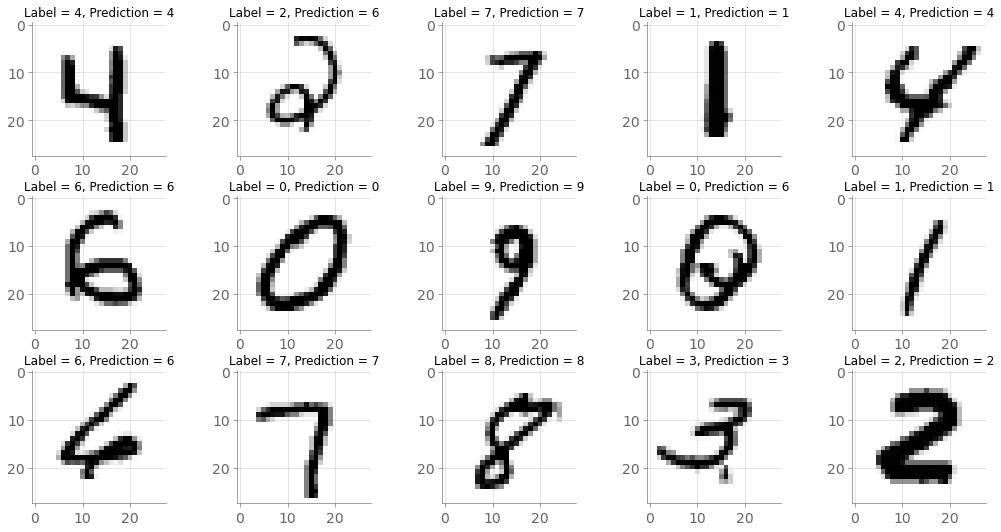

In [23]:
# how does the prediction look like?
plt.rcParams['figure.figsize'] = 16, 8

fig, ax = plt.subplots(3, 5)
plt.subplots_adjust(hspace=0.3)
perm = np.random.permutation(X_test.shape[1])[:15]
for i, n in enumerate(perm):
    ax[i // 5][i % 5].imshow(X_test[:,n].reshape(28, 28), cmap=plt.cm.gray_r, interpolation='nearest', vmin=0, vmax=1)
    prediction = np.argmax(feed_forward(X_test[:, n:n+1], params)['A3'])
    label = np.argmax(Y_test[:, n:n+1])
    ax[i // 5][i % 5].set_title(f'Label = {label}, Prediction = {prediction}')
plt.rcParams['figure.figsize'] = 12, 6

In [25]:
# look at precision and recall
pred_test = np.argmax(feed_forward(X_test, params)['A3'], axis=0)
true_test = np.argmax(Y_test, axis=0)

avg_precision = 0
avg_recall = 0
for i in range(10):
    support = np.sum(true_test == i)
    precision = np.sum((pred_test == i) & (pred_test == true_test)) / np.sum(pred_test == i)
    recall = np.sum((pred_test == i) & (pred_test == true_test)) / np.sum(true_test == i)
    avg_precision = avg_precision + precision
    avg_recall = avg_recall + recall
    print(f'#{i}: precision = {precision:.3g}, recall = {recall:.3g}, support = {support}')
    
print('---------------')
print(f'Avg precision = {avg_precision / 10:.3g}, avg recall = {avg_recall / 10:.3g}')

#0: precision = 0.906, recall = 0.966, support = 963
#1: precision = 0.943, recall = 0.965, support = 1142
#2: precision = 0.93, recall = 0.842, support = 995
#3: precision = 0.909, recall = 0.863, support = 1017
#4: precision = 0.881, recall = 0.909, support = 960
#5: precision = 0.867, recall = 0.846, support = 922
#6: precision = 0.936, recall = 0.944, support = 1001
#7: precision = 0.893, recall = 0.951, support = 1013
#8: precision = 0.887, recall = 0.847, support = 1001
#9: precision = 0.855, recall = 0.869, support = 986
---------------
Avg precision = 0.901, avg recall = 0.9


### 4. Iteration over data and learning

Connect all the pieces together and send the data through the network several times.

In [22]:
# training
start_time = time.time()

train_losses = []
test_losses = []

for i in range(epochs):

    # shuffle training set
    permutation = np.random.permutation(X_train.shape[1])
    X_train_shuffled = X_train[:, permutation]
    Y_train_shuffled = Y_train[:, permutation]

    batches = (X_train_shuffled.shape[0] - 1) // batch_size + 1

    for j in range(batches):

        # get mini-batch
        begin = j * batch_size
        end = min(begin + batch_size, X_train.shape[1] - 1)
        X = X_train_shuffled[:, begin:end]
        Y = Y_train_shuffled[:, begin:end]
        m_batch = end - begin

        # forward and backward
        cache = feed_forward(X, params)
        grads = back_propagate(X, Y, params, cache, m_batch)
        
        # gradient descent
        params['W1'] = params['W1'] - lr * grads['dW1']
        params['b1'] = params['b1'] - lr * grads['db1']
        params['W2'] = params['W2'] - lr * grads['dW2']
        params['b2'] = params['b2'] - lr * grads['db2']
        params['W3'] = params['W3'] - lr * grads['dW3']
        params['b3'] = params['b3'] - lr * grads['db3']

    # forward pass on training set
    cache = feed_forward(X_train, params)
    train_loss = loss_mean_squared_errors(Y_train, cache['A3'])
    train_losses.append(train_loss)

    # forward pass on test set
    cache = feed_forward(X_test, params)
    test_loss = loss_mean_squared_errors(Y_test, cache['A3'])
    test_losses.append(test_loss)
    
    print(f'Epoch {i+1}, time spent {time.time() - start_time:.2f}s: '
          f'training loss = {train_loss:.3g}, test loss = {test_loss:.3g}')


Epoch 1, time spent 1.92s: training loss = 0.9, test loss = 0.9
Epoch 2, time spent 3.95s: training loss = 0.898, test loss = 0.897
Epoch 3, time spent 5.96s: training loss = 0.896, test loss = 0.896
Epoch 4, time spent 8.03s: training loss = 0.896, test loss = 0.896
Epoch 5, time spent 9.99s: training loss = 0.893, test loss = 0.893
Epoch 6, time spent 12.05s: training loss = 0.891, test loss = 0.891
Epoch 7, time spent 14.10s: training loss = 0.887, test loss = 0.887
Epoch 8, time spent 16.23s: training loss = 0.882, test loss = 0.882
Epoch 9, time spent 18.17s: training loss = 0.876, test loss = 0.876
Epoch 10, time spent 20.20s: training loss = 0.869, test loss = 0.868
Epoch 11, time spent 22.21s: training loss = 0.859, test loss = 0.858
Epoch 12, time spent 24.11s: training loss = 0.845, test loss = 0.845
Epoch 13, time spent 26.16s: training loss = 0.831, test loss = 0.831
Epoch 14, time spent 28.10s: training loss = 0.817, test loss = 0.817
Epoch 15, time spent 30.06s: training 

Epoch 118, time spent 231.35s: training loss = 0.17, test loss = 0.172
Epoch 119, time spent 233.28s: training loss = 0.169, test loss = 0.172
Epoch 120, time spent 235.22s: training loss = 0.173, test loss = 0.175


### 5b. Additional inspection

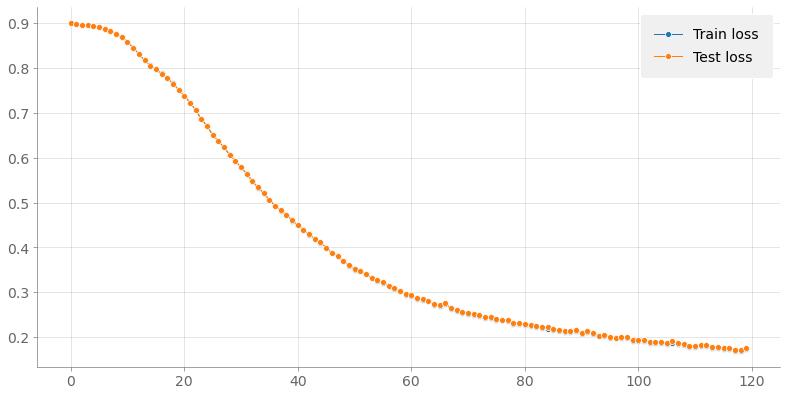

In [26]:
# plot the losses
sns.lineplot(range(len(train_losses)), train_losses, label='Train loss', marker='o')
sns.lineplot(range(len(train_losses)), test_losses, label='Test loss', marker='o')

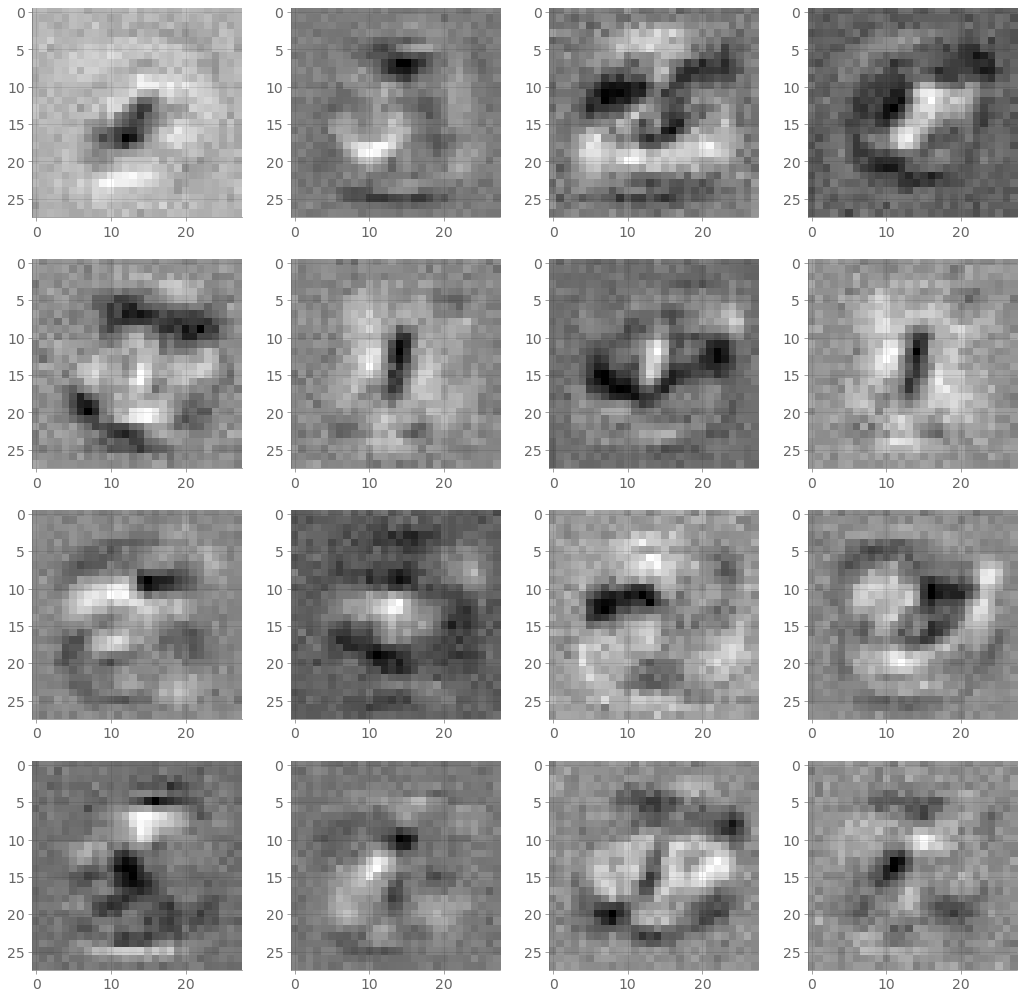

In [27]:
# inspect the weights
plt.rcParams['figure.figsize'] = 16, 16

fig, ax = plt.subplots(4, 4)
for i in range(16):
    ax[i // 4][i % 4].imshow(params['W1'][i, :].reshape(28, 28), cmap=plt.cm.gray_r, interpolation='nearest')
plt.rcParams['figure.figsize'] = 12, 6

## Can we do better?

**Small tweaks...**
- bigger hidden layers
- different last layer activation (softmax instead of sigmoid)
- different cost function (cross entropy instead of mean squared errors)

**...or we can use more suitable architecture**
- convolutional neural networks (CNN, ConvNet) instead of fully connected network

## In practice

Use a deep learning framework, it handles all the fiddly mathematical operations for you.

![Deep Learning Frameworks](img/dl-frameworks.jpg)

Definition of your neural network then looks like Lego:
- https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/
- the neural network defined below has more complex architecture (convolutional network, we will learn more about it during the next session)
- the code will not work as you do not have TensorFlow and Keras installed

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))
# compile model
opt = SGD(lr=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

And training with evaluation on test dataset:

In [ ]:
_ = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
_ = model.evaluate(testX, testY, verbose=0)

So you will spend most of your time on data preparation, cleaning, reshaping. And then inspecting why your model is not working as expected...